In [146]:
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,Subset
from torch import Tensor
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import json
import time
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange
import math
import onnx #onnx and onnxscript are used to export our model to Unity for engineering project
import onnxscript
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

mne.set_log_level('ERROR')
mne.cuda.init_cuda(verbose=True)

In [2]:
print(device)

cuda


In [3]:
# Used to read our json file of each dictionary mapped to it's file name
def read_dict_from_json_file(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [158]:
class CHBData(Dataset):
    def __init__(self, segment_dict):
        self.segment_dict = segment_dict
        # Mapping label names to integers
        self.label_to_int = {'interictal': 0, 'preictal': 1, 'ictal': 2}

    def __len__(self):
        return len(self.segment_dict)

    def __getitem__(self, index,):
        
        segment = torch.load(f'CHB-MIT/Segments/chb01/{index}-chb01.pt')
        #segment = segment.unsqueeze(0)
        segment = self.pad_sequence(segment)
        
        # Retrieve the label and map it to an integer
        label_name = self.segment_dict[f'CHB-MIT/Segments/chb01/{index}-chb01.pt']
        label = self.label_to_int[label_name]
        segment = segment.float().to(device)
        return segment, label
    def pad_sequence(self,segment):
        # Find the padding required to make the shape of the tensor have a height of 28 (the greatest amount of channels in CHB-MIT)
        total_padding = 28-segment.shape[1]
        pad_top = total_padding // 2
        pad_bottom = total_padding - pad_top

        # Apply padding
        # Padding format is (left, right, top, bottom) for the last two dimensions
        padded_tensor = F.pad(segment, (0, 0, pad_top, pad_bottom), mode='constant', value=0)

        return padded_tensor

In [154]:
segment_dict = read_dict_from_json_file('CHB-MIT/segment_dict1.json')

In [159]:
num_workers = 0
full_dataset = CHBData(segment_dict)

# Split the dataset into train and test sets
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42)

#  split the test set into validation and actual test sets

# dataloaders for training, validation, and test
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Instantiate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)


In [156]:
train_dataset.__len__()

102191

In [123]:
class SeizureSense(nn.Module):
    
    def __init__(self):
        super(SeizureSense,self).__init__()
        
        #Block 1
        #should be taking in an input of 23x512
        #first layer temporal filters
        self.conv1=nn.Conv2d(1,8,(1,128),stride=1,padding=0)
        self.batchnorm1 = nn.BatchNorm2d(8, False)
        
        #spatial layer(depthwise layer)
        self.conv2_23=nn.Conv2d(8,32,(28,1))
        self.batchnorm2 = nn.BatchNorm2d(32, False)
        self.avgpool1 = nn.AvgPool2d((1,2))
        #apply dropout here in forward
        
        
        #Block 2
        #sepereable convolutional 2d
        self.conv3=nn.Conv2d(32,32,(1,16),stride=1)
        self.batchnorm3 = nn.BatchNorm2d(32,False) #CHECK THIS!
        #self.avgpool2 = nn.AvgPool2d((1,16))
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,3))


        
        #Block 3
        
        self.fc1= nn.Linear(96, 30)
        self.fc2=nn.Linear(30,3)

        #apply dropout here in forward
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.elu(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)    
        x = self.conv2_23(x)
        x = F.elu(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.avgpool1(x)
        
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        #x = self.avgpool2(x)
        x = self.adaptivepool(x)
        x = x.view(x.size(0), -1)  # Adjust this based on the output size of adaptive pooling
        x = self.fc1(x)
        x = F.elu(x)
        x = torch.sigmoid(self.fc2(x))  # Use torch.sigmoid instead of F.sigmoid (deprecated)
        return x

In [163]:
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        # self.patch_size = patch_size
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (22, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),  # pooling acts as slicing to obtain 'patch' along the time dimension as in ViT
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # transpose, conv could enhance fiting ability slightly
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*1.0+torch.erf(input/math.sqrt(2.0))

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=10,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes, d_hidden):
        super().__init__()
        
        # global average pooling
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(emb_size, d_hidden),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(d_hidden, n_classes)
        )

    def forward(self, x):
        #x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)
        return out



class Conformer(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=3, **kwargs):
        super().__init__(

            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes, 256)
        )

In [164]:
model=Conformer()
model.to(device)

Conformer(
  (0): PatchEmbedding(
    (shallownet): Sequential(
      (0): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
      (1): Conv2d(40, 40, kernel_size=(22, 1), stride=(1, 1))
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
      (5): Dropout(p=0.5, inplace=False)
    )
    (projection): Sequential(
      (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (keys): Linear(in_features=40, out_features=40, bias=True)
            (queries): Linear(in_features=40, out_features=40, bias=True)
            (values): Linear(in_features=40, out_features=40, bias=True

In [28]:
optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

Optimal threshold: 0.08260418474674225


In [139]:
optimal_threshold = 0.082604


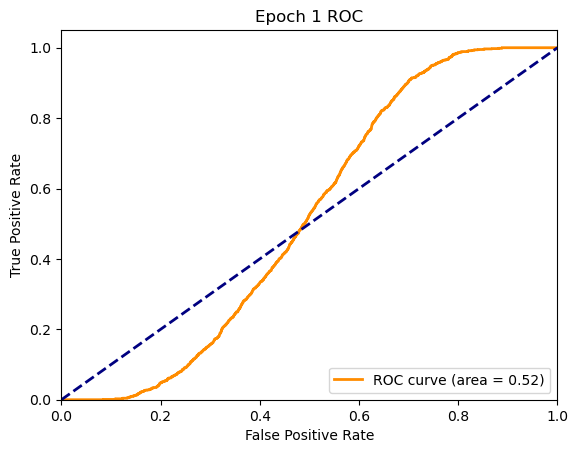

Epoch 1/5 - Loss: 0.1280, Accuracy: 0.9699, Recall: 0.0000, AUROC: 0.5163


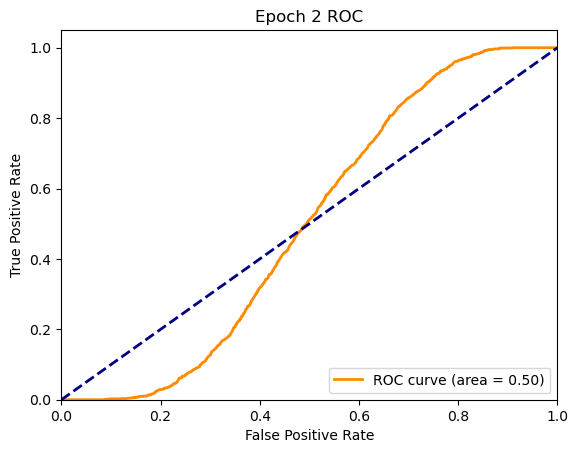

Epoch 2/5 - Loss: 0.1032, Accuracy: 0.9699, Recall: 0.0000, AUROC: 0.4989


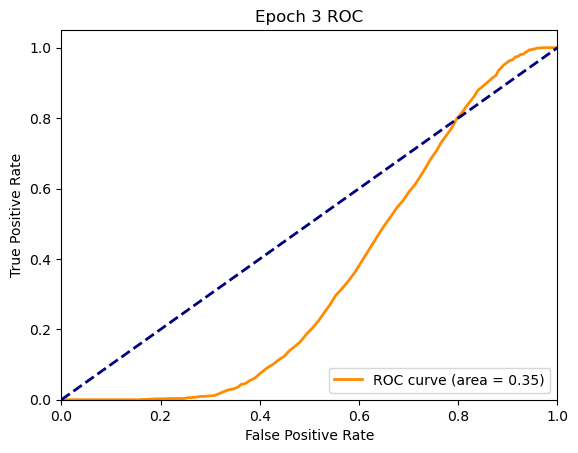

Epoch 3/5 - Loss: 0.1017, Accuracy: 0.9699, Recall: 0.0000, AUROC: 0.3516


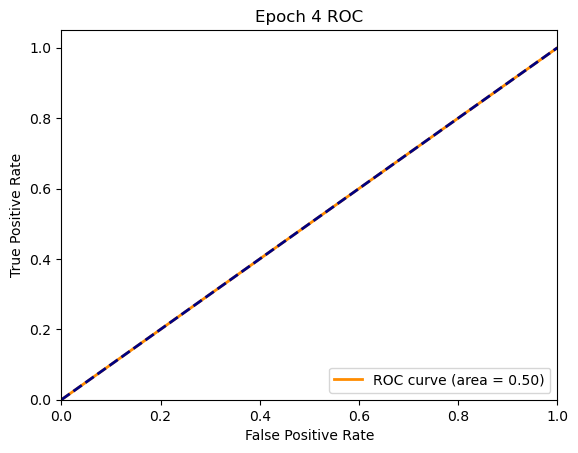

Epoch 4/5 - Loss: 0.0990, Accuracy: 0.9699, Recall: 0.0000, AUROC: 0.5000


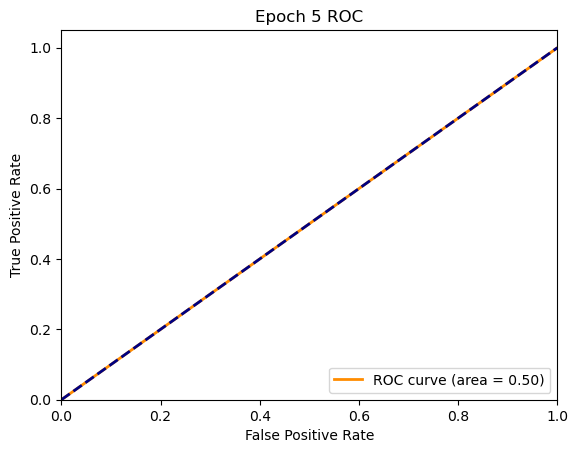

Epoch 5/5 - Loss: 0.0969, Accuracy: 0.9699, Recall: 0.0000, AUROC: 0.5000


In [165]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
num_classes = 3
losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start timing
    
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        agregated_outputs=outputs.mean(dim=1)
        
        loss = criterion(agregated_outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    # Validation Phase
    model.eval()
    val_labels = []
    val_probabilities = []  # Store probabilities for AUROC calculation
    val_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            logits = model(inputs)
            agregated_logits=logits.mean(dim=1)
            outputs = F.softmax(agregated_logits, dim=1)            
            
            positive_class_probabilities = outputs[:, 1]
            predictions = (positive_class_probabilities.cpu().numpy() > optimal_threshold).astype(int)
            
            val_labels.extend(labels.cpu().numpy())  # Convert to numpy array
            val_predictions.extend(predictions)
            val_probabilities.extend(outputs.cpu().numpy())  # Convert to numpy array
    
    # Calculate metrics
    accuracy = accuracy_score(val_labels, val_predictions)
    recall = recall_score(val_labels,val_predictions, average=None)[1]
    # Calculate AUROC
    # For multi-class AUROC, we need to binarize the labels
    val_labels_binarized = label_binarize(val_labels, classes=range(num_classes))[:,1]
    val_probabilities_array = np.array(val_probabilities)
    auroc = roc_auc_score(val_labels_binarized, val_probabilities_array[:,1])
    
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(val_labels_binarized, val_probabilities_array[:,1])
    roc_auc = auc(fpr, tpr)  # Recalculate AUROC using AUC function for consistency in plotting

    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Epoch {epoch+1} ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {np.mean(losses):.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, AUROC: {auroc:.4f}')

    # Reset losses for next epoch
    losses = []

In [31]:
torch.save(model.state_dict(), 'SeizureSenseStateDict.pth')

In [166]:

optimal_threshold=.3 #actual=.087
def decode_predictions(predictions):
    agregated_outputs=predictions.mean(dim=1)
    probabilities=F.softmax(agregated_outputs,dim=-1)
    print(probabilities)
    if probabilities[0][1]>optimal_threshold:
        return 'preictal'
    else:
        max_values, max_indices = torch.max(probabilities, dim=1)
        if max_indices==0:
            return 'interictal'
        else:
            return 'ictal'

In [176]:
input=torch.rand((1,1,28,256)).float()

model.eval()
with torch.no_grad():  # Disable gradient computation for inference
    predictions = model(input.to(device))
    print(predictions.shape)
    #print(predictions)
    
    print(decode_predictions(predictions))
    #predictions=decode_predictions(predictions)
    #print('Predictions:',predictions)


torch.Size([1, 77, 3])
tensor([[1., 0., 0.]], device='cuda:0')
interictal
